<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/02_svm_deception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
PROJECT_DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PROJECT_DRIVE_DIR, exist_ok=True)
print("Drive project folder:", PROJECT_DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive project folder: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [45]:
cd /content/drive/MyDrive/Colab\ Notebooks/airbnb_nz_deception_sentiment

/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [46]:
import pandas as pd

# Load dataset
df = pd.read_csv("data/deceptive_opinion.csv")

# 1. Check basic info
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   hotel      1600 non-null   object
 2   polarity   1600 non-null   object
 3   source     1600 non-null   object
 4   text       1600 non-null   object
dtypes: object(5)
memory usage: 62.6+ KB
None
  deceptive   hotel  polarity       source  \
0  truthful  conrad  positive  TripAdvisor   
1  truthful   hyatt  positive  TripAdvisor   
2  truthful   hyatt  positive  TripAdvisor   
3  truthful    omni  positive  TripAdvisor   
4  truthful   hyatt  positive  TripAdvisor   

                                                text  
0  We stayed for a one night getaway with family ...  
1  Triple A rate with upgrade to view room was le...  
2  This comes a little late as I'm finally catchi...  
3  The Omni Chicago really delivers on all fronts...  
4  I asked for a high f

In [47]:
# 2. Check missing values
print("Missing values per column:\n", df.isna().sum())

# 3. Check duplicates
dup_texts = df.duplicated(subset=["text"]).sum()
df = df.drop_duplicates(subset=["text"], keep="first").copy()
print(f"[Duplicate Reviews] Removed {dup_texts:,} identical comment texts → {len(df):,} remain.")


# 4. Label distribution
print("Label distribution:")
print(df["deceptive"].value_counts())

# If labels are strings, map them to numeric
label_map = {"truthful": 0, "deceptive": 1}
df["label"] = df["deceptive"].map(label_map)

# 5. Class balance summary
total = len(df)
for lbl, count in df["label"].value_counts().items():
    pct = (count / total) * 100
    print(f"Class {lbl} ({'deceptive' if lbl==1 else 'truthful'}): {count} ({pct:.2f}%)")

# check text length check
df["length"] = df["text"].str.split().apply(len)
print("Average review length (in words):", df["length"].mean())
print("Shortest:", df["length"].min(), "| Longest:", df["length"].max())

Missing values per column:
 deceptive    0
hotel        0
polarity     0
source       0
text         0
dtype: int64
[Duplicate Reviews] Removed 4 identical comment texts → 1,596 remain.
Label distribution:
deceptive
deceptive    800
truthful     796
Name: count, dtype: int64
Class 1 (deceptive): 800 (50.13%)
Class 0 (truthful): 796 (49.87%)
Average review length (in words): 148.71804511278197
Shortest: 25 | Longest: 784


In [48]:
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib
import matplotlib.pyplot as plt

RANDOM_STATE = 42
ARTIFACTS_DIR = Path("artifacts/deception_svm")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

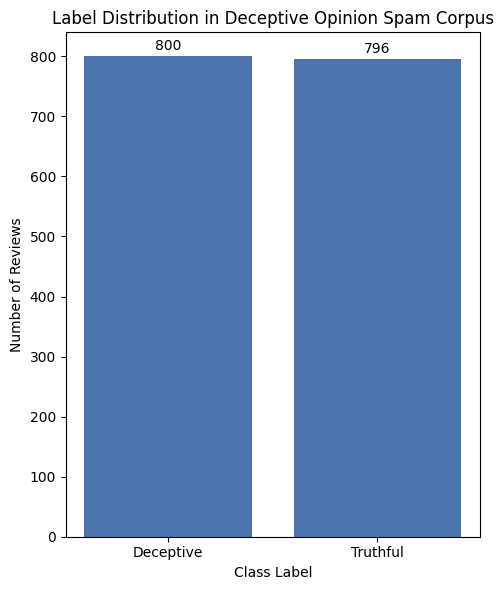

In [52]:
import matplotlib.pyplot as plt

label_type = {0: "Truthful", 1: "Deceptive"}

# Count per class
counts = df["label"].value_counts().rename(index=label_type).sort_index()

# --- Plot ---
plt.figure(figsize=(5,6))
bars = plt.bar(counts.index, counts.values, color="#4C72B0")
plt.title("Label Distribution in Deceptive Opinion Spam Corpus")
plt.ylabel("Number of Reviews")
plt.xlabel("Class Label")

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("figures/deceptive_opinion_label_distribution.png", dpi=300)
plt.show()

In [53]:
print(df["label"].value_counts(dropna=False))
print(df.head(2))

label
1    800
0    796
Name: count, dtype: int64
  deceptive   hotel  polarity       source  \
0  truthful  conrad  positive  TripAdvisor   
1  truthful   hyatt  positive  TripAdvisor   

                                                text  label  length  
0  We stayed for a one night getaway with family ...      0     105  
1  Triple A rate with upgrade to view room was le...      0      45  


In [54]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=RANDOM_STATE, stratify=df["label"]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 1276 | Val: 160 | Test: 160


In [55]:
# Pipeline: TF-IDF (1–2 grams) -> LinearSVC
# Characteristic setup that works well for deception datasets: 1–2 n-grams, sublinear TF, min_df to ignore rare tokens.
svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(random_state=RANDOM_STATE))
])

In [56]:
# Hyperparameter search
param_grid = {
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    svm_pipe,
    param_grid=param_grid,
    scoring="f1",  # macro or binary; binary f1 assumes positive class=1 (deceptive)
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (F1):", grid.best_score_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'clf__C': 4.0}
Best CV score (F1): 0.8956235076893282


In [57]:
# Validate
y_val_pred = best_model.predict(X_val)
print("\nVALIDATION")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 (deceptive=1):", f1_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=["truthful","deceptive"]))


VALIDATION
Accuracy: 0.9125
F1 (deceptive=1): 0.9135802469135802
              precision    recall  f1-score   support

    truthful       0.92      0.90      0.91        80
   deceptive       0.90      0.93      0.91        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



In [58]:
# 6) Test
y_test_pred = best_model.predict(X_test)
print("\nTEST")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1 (deceptive=1):", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=["truthful","deceptive"]))

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix (test):\n", cm)


TEST
Accuracy: 0.86875
F1 (deceptive=1): 0.8727272727272727
              precision    recall  f1-score   support

    truthful       0.89      0.84      0.86        80
   deceptive       0.85      0.90      0.87        80

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160

Confusion matrix (test):
 [[67 13]
 [ 8 72]]


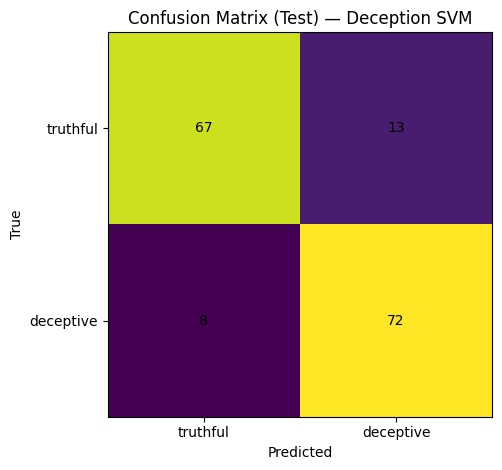

In [59]:
# CM plot
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test) — Deception SVM")
plt.xticks([0,1], ["truthful","deceptive"])
plt.yticks([0,1], ["truthful","deceptive"])
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted");
plt.ylabel("True");
plt.tight_layout();
plt.show()

In [60]:
# 7) Save artifacts
joblib.dump(best_model, ARTIFACTS_DIR / "svm_deception_pipeline.joblib")
joblib.dump({"truthful":0, "deceptive":1}, ARTIFACTS_DIR / "label_map.joblib")
print("Saved model & label map to:", ARTIFACTS_DIR.resolve())

Saved model & label map to: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/deception_svm


In [61]:
# Inference helper to reuse
def predict_deception(texts, pipeline_path=ARTIFACTS_DIR / "svm_deception_pipeline.joblib"):
    model = joblib.load(pipeline_path)
    preds = model.predict(texts)
    return preds  # 0 truthful, 1 deceptive

# Example:
preds = predict_deception(pd.Series(["The hotel was lovely, great service!", "Totally fake vibe..."]))
print(preds)

[0 0]
